In [1]:
#@title 安裝libtiff
%%capture
try:
  from libtiff import TIFF
except: 
  !pip install libtiff

# 將某行程式註解
# script_path = '/usr/local/lib/python3.7/dist-packages/libtiff/libtiff_ctypes.py'
# script = !cat {script_path}
# if '#' not in script[1188]:
#   script[1188] = '#' + script[1188]
#   f = open(script_path, "w")
#   f.write(''.join([s+'\n' for s in script]))
#   f.close()
#   exit()

In [2]:
#@title 設定圖片
import cv2
from google.colab.patches import cv2_imshow
cv2.imshow = cv2_imshow
import numpy as np
from copy import copy
import pandas as pd
import os

choose = 'CoP' #@param ['CoP', 'Fish', 'Veg']

image = {
  'CoP':['CoP.jpg','https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTJ6sLtvjXCKjGxtmkV3FqxWk3O9WwSuvCE1g&usqp=CAU'],
  'Fish':['Fish.jpg','https://d32kak7w9u5ewj.cloudfront.net/media/image/2018/11/2e6888eb9fb4481d936af71854b55f66.jpg'],
  'Veg':['Veg.jpg','https://gdb.voanews.com/DD9EFE8A-F787-4FB1-B0DC-39E627C2DB04_w408_r1_s.jpg']
}
!wget -O {image[choose][0]} {image[choose][1]}
img = cv2.imread(image[choose][0])

--2022-02-13 11:23:36--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTJ6sLtvjXCKjGxtmkV3FqxWk3O9WwSuvCE1g
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 173.194.217.113, 173.194.217.100, 173.194.217.101, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|173.194.217.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5352 (5.2K) [image/jpeg]
Saving to: ‘CoP.jpg’

CoP.jpg             100%[===================>]   5.23K  --.-KB/s    in 0s      

2022-02-13 11:23:36 (38.5 MB/s) - ‘CoP.jpg’ saved [5352/5352]



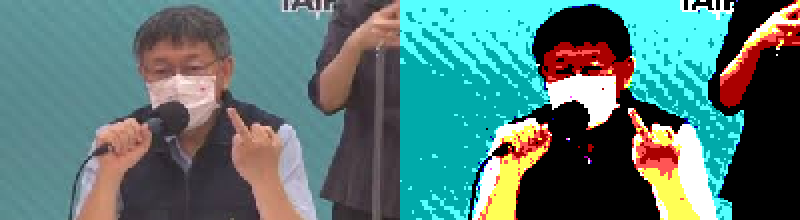

In [3]:
#@title Subsampling & Quantization

 # B, G, R,
palette = np.array([
  [0,0,0],
  [170,0,0],
  [0,170,0],
  [170,170,0],
  [0,0,170],
  [170,0,170],
  [0,170,170], #[0,85,170],
  [170,170,170],
  [85,85,85],
  [255,85,85],
  [85,255,85],
  [255,255,85],
  [85,85,255],
  [255,85,255],
  [85,255,255],
  [255,255,255],
])

def C256toC16(img):
  img = copy(img)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      if img[i,j,:].mean()>128:
        for k in range(3):
          img[i,j,k] = 255 if img[i,j,k]>127 else 85
      else:
        for k in range(3):
          img[i,j,k] = 170 if img[i,j,k]>127 else 0
  return img

def C16to8086(img):
  img = copy(img)
  img2 = np.zeros(shape=img.shape[:2],dtype=int)
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
     img2[i,j] = np.where(np.all((palette==img[i,j,:]),axis=1))[0][0]
  return img2

def _8086toC16(img):
  img = copy(img)
  img = np.where(img>15,15,img)
  return palette[img]

def show(img_list):
  for i in range(len(img_list)):
    try:
      img_list[i] = cv2.resize(img_list[i], (400,220), interpolation=cv2.INTER_NEAREST)
    except:
      pass
  for i in range(0,len(img_list),2):
    try:
      cv2.imshow(np.hstack([img_list[i],img_list[i+1]]))
    except:
      cv2.imshow(img_list[i])

img2 = cv2.resize(img, (200,110), interpolation=cv2.INTER_NEAREST)
img3 = C256toC16(img2)
img4 = C16to8086(img3)

show([img2,img3])

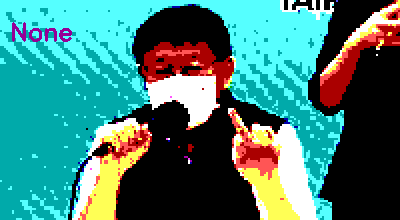

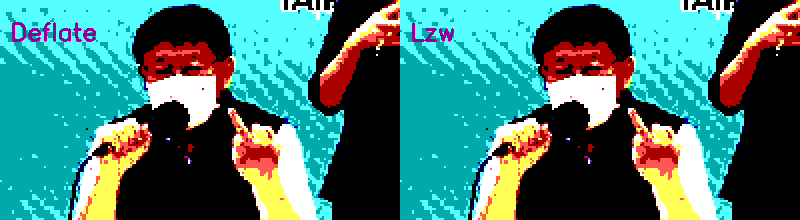

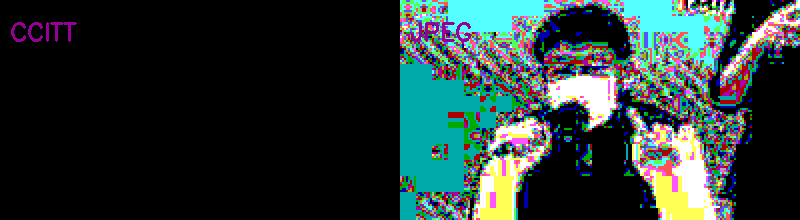

Deflate檔案大小: 22134 B -> 2712 B, 壓縮比: 8.16150442477876
Lzw檔案大小:	 22134 B -> 3420 B, 壓縮比: 6.471929824561403
CCITT檔案大小:	 22134 B -> X B, 壓縮比: X
JPEG檔案大小:	 22134 B -> 1641 B, 壓縮比: 13.488117001828154


In [4]:
#@title 各方式壓縮(.tif)
def read_pic(path):
  gray = cv2.cvtColor(cv2.imread(path),cv2.COLOR_BGR2GRAY)
  return _8086toC16(gray)

def add_label(img,label):
  img2 = cv2.resize(img, (400,220), interpolation=cv2.INTER_NEAREST)
  img2 = cv2.putText(img2, label, (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (150,0,150), 2)
  return img2

from libtiff import TIFF

img5 = img4.astype('uint8')
TIFF.open('none.tiff', mode='w').write_image(img5, compression=None)
TIFF.open('deflate.tiff', mode='w').write_image(img5, compression='deflate')
TIFF.open('lzw.tiff', mode='w').write_image(img5, compression='lzw')
# TIFF.open('ccitt.tiff', mode='w').write_image(img5, compression='CCITT_T6')
TIFF.open('jp2000.tiff', mode='w').write_image(img5, compression='jpeg')

img_tiff_none = TIFF.open('none.tiff', mode='r').read_image()
img_tiff_deflate = TIFF.open('deflate.tiff', mode='r').read_image()
img_tiff_lzw = TIFF.open('lzw.tiff', mode='r').read_image()
img_tiff_ccitt = np.full([110,200],0)# img_tiff_ccitt = TIFF.open('ccitt.tiff', mode='r').read_image()
img_tiff_jpeg = TIFF.open('jp2000.tiff', mode='r').read_image()

img_list = [
  add_label(_8086toC16(img_tiff_none),'None'),
  None,           
  add_label(_8086toC16(img_tiff_deflate),'Deflate'),
  add_label(_8086toC16(img_tiff_lzw),'Lzw'),
  add_label(_8086toC16(img_tiff_ccitt),'CCITT'),
  add_label(_8086toC16(img_tiff_jpeg),'JPEG'),
]

show(img_list)

none_size = os.path.getsize('none.tiff')
deflate_size = os.path.getsize('deflate.tiff')
lzw_size = os.path.getsize('lzw.tiff')
# ccitt_size = os.path.getsize('ccitt.tiff')
jpeg_size = os.path.getsize('jp2000.tiff')

print('Deflate檔案大小:',none_size,'B ->',deflate_size,'B, 壓縮比:',none_size/deflate_size)
print('Lzw檔案大小:\t',none_size,'B ->',lzw_size,'B, 壓縮比:',none_size/lzw_size)
print('CCITT檔案大小:\t',none_size,'B ->','X','B, 壓縮比:','X')
print('JPEG檔案大小:\t',none_size,'B ->',jpeg_size,'B, 壓縮比:',none_size/jpeg_size)


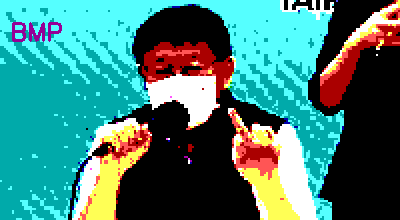

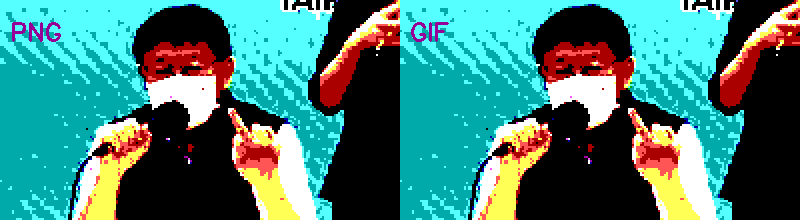

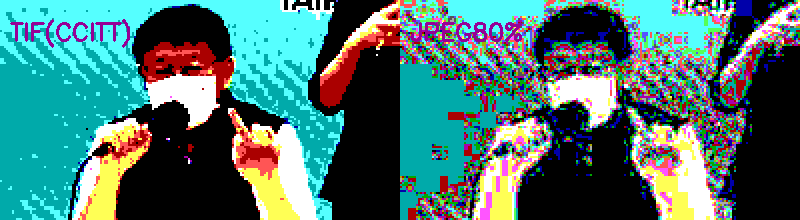

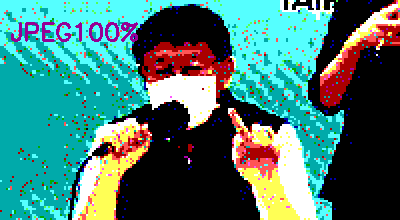

PNG檔案大小: 23078 B -> 3191 B, 壓縮比: 7.23221560639298
GIF檔案大小: 23078 B -> 10035 B, 壓縮比: 2.299750871948181
TIF檔案大小: 23078 B -> 4762 B, 壓縮比: 4.846283074338513
JPEG_80%檔案大小: 23078 B -> 1706 B, 壓縮比: 13.527549824150059
JPEG_100%檔案大小: 23078 B -> 7634 B, 壓縮比: 3.0230547550432276


In [5]:
#@title 各壓縮檔案
from PIL import Image 
def GrayToBool(img):
  image = np.zeros(shape=[img.shape[0],img.shape[1]*4],dtype='bool')
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      image[i,4*j:4*j+4] = [img[i,j]//8%2!=0,img[i,j]//4%2!=0,img[i,j]//2%2!=0,img[i,j]//1%2!=0]
  return image

def BoolToGray(img):
  image = np.zeros(shape=[img.shape[0],img.shape[1]//4],dtype='uint8')
  for i in range(img.shape[0]):
    for j in range(0,img.shape[1],4):
      image[i,j//4] = 8*img[i,j] + 4*img[i,j+1] + 2*img[i,j+2] + img[i,j+3]
  return image 

def get_palette(path):
  image = Image.open(path)
  palette_data = str(image.palette.getdata()[1])
  # palette = np.array([],dtype='uint8')
  # while True:
  #   index = palette_data.find('x0')
  #   try:
  #     num = int(palette_data[index+2],16)
  #   except:
  #     return palette
  #   if num not in palette:
  #     palette = np.append(palette,num)
  #   palette_data = palette_data[index+3:]
  palette = np.array([0,1,2,3,4,5,6,9,11,12,13,14,15],dtype='uint8')
  first_code = palette_data[palette_data.find('x0')+2]
  if first_code == 'f':
    palette = palette[::-1]
  return palette

image = Image.fromarray(img4.astype('uint8'))
image.save('img.bmp')
image.save('img.png')
image.save('img.gif'); pale = get_palette('img.gif')
image.save('img_80.jpeg',quality=80)
image.save('img_100.jpeg',quality=100)

image = Image.fromarray(GrayToBool(img4))
image.save('img.tif',compression="group4")

img_list = [
  add_label(_8086toC16(np.array(Image.open('img.bmp'))),'BMP'),
  None,            
  add_label(_8086toC16(np.array(Image.open('img.png'))),'PNG'),
  add_label(_8086toC16(pale[np.array(Image.open('img.gif'))]),'GIF'),
  add_label(_8086toC16(BoolToGray(np.array(Image.open('img.tif')))),'TIF(CCITT)'),
  add_label(_8086toC16(np.array(Image.open('img_80.jpeg'))),'JPEG80%'),
  add_label(_8086toC16(np.array(Image.open('img_100.jpeg'))),'JPEG100%'),
]

show(img_list)


bmp_size = os.path.getsize('img.bmp')
png_size = os.path.getsize('img.png')
gif_size = os.path.getsize('img.gif')
tif_size = os.path.getsize('img.tif')
jpeg80_size = os.path.getsize('img_80.jpeg')
jpeg100_size = os.path.getsize('img_100.jpeg')

print('PNG檔案大小:',bmp_size,'B ->',png_size,'B, 壓縮比:',bmp_size/png_size)
print('GIF檔案大小:',bmp_size,'B ->',gif_size,'B, 壓縮比:',bmp_size/gif_size)
print('TIF檔案大小:',bmp_size,'B ->',tif_size,'B, 壓縮比:',bmp_size/tif_size)
print('JPEG_80%檔案大小:',bmp_size,'B ->',jpeg80_size,'B, 壓縮比:',bmp_size/jpeg80_size)
print('JPEG_100%檔案大小:',bmp_size,'B ->',jpeg100_size,'B, 壓縮比:',bmp_size/jpeg100_size)

以編碼(0~15)壓縮，因為JPEG無論如何會消除一些低頻，如果是灰階或全彩不會看出差異
但編碼順序是沒有邏輯的，所以解壓縮回去看起來失真非常多


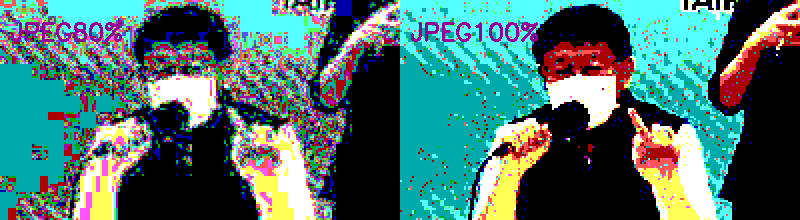

以全彩壓縮便看不出差異


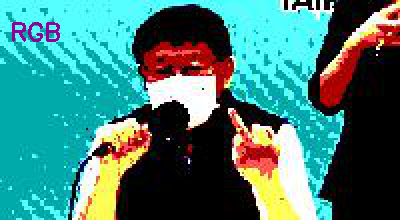

In [6]:
#@title 全彩圖案(未編碼成0~15)JPEG壓縮
print('以編碼(0~15)壓縮，因為JPEG無論如何會消除一些低頻，如果是灰階或全彩不會看出差異')
print('但編碼順序是沒有邏輯的，所以解壓縮回去看起來失真非常多')
show(img_list[5:])
print('以全彩壓縮便看不出差異')
image = cv2.cvtColor(img3.astype('uint8'),cv2.COLOR_BGR2RGB)
image = Image.fromarray(image)
image.save('img.jpeg')
show([add_label(cv2.cvtColor(np.array(Image.open('img.jpeg')), cv2.COLOR_RGB2BGR),'RGB')])
